## Project Overview & Objectives

This notebook develops a deep learning pipeline to classify breast cancer biopsy images into diagnostic subtypes using the BACH dataset. It focuses on an end-to-end workflow: from data loading and preprocessing to model training, evaluation, and inference. The goal is to obtain a reliable, reproducible baseline for subtype classification.


## Environment Setup & Imports

In this section, we mount the drive (for Colab), import the required Python libraries, and configure the compute device (CPU or GPU). A consistent environment is essential for reproducibility and for running the notebook on different machines.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import torch
import cv2
import csv
import time
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from tqdm.notebook import tqdm
import torchvision.transforms.functional as TF


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [10]:
class config:
    batchsize = 8
    num_epochs = 50
    learning_rate = 1e-4
    num_classes = 4

In [11]:
pd.set_option('future.no_silent_downcasting', True)

## Data Loading, Labels, and Splits

Here we locate the BACH image files, read the ground truth annotations, and construct label mappings. The dataset is then split into training, validation, and test sets to ensure that evaluation is performed on unseen data while preserving class balance as much as possible.


In [ ]:
dataset_path = "./drive/MyDrive/umich_courses/1_fall_2025/1_term_project/data/BACH/ICIAR2018_BACH_Challenge/Photos"
csv_path = "./drive/MyDrive/umich_courses/1_fall_2025/1_term_project/data/BACH/ICIAR2018_BACH_Challenge/Photos/microscopy_ground_truth.csv"


In [ ]:
df = pd.read_csv(csv_path)
image_paths, labels = [], []

for class_name in ["Benign", "InSitu", "Invasive", "Normal"]:
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        if img_name.endswith(".tif"):
            image_paths.append(os.path.join(class_path, img_name))
            labels.append(class_name)


image_df = pd.DataFrame({"image_path": image_paths, "label": labels})

image_df["label"] = image_df["label"].replace({"Normal": 0, "Benign": 1, "InSitu": 2, "Invasive": 3}).astype("int64")
image_df = image_df.sample(frac=1, random_state=42).reset_index(drop=True)
image_df.to_csv("bach_training_data.csv", index=False)

dataset = pd.read_csv("bach_training_data.csv")
dataset.head()

,image_path,label
0,./drive/MyDrive/umich_courses/1_fall_2025/1_te...,3
1,./drive/MyDrive/umich_courses/1_fall_2025/1_te...,3
2,./drive/MyDrive/umich_courses/1_fall_2025/1_te...,1
3,./drive/MyDrive/umich_courses/1_fall_2025/1_te...,3
4,./drive/MyDrive/umich_courses/1_fall_2025/1_te...,1


## Preprocessing, Augmentation, and DataLoaders

This section defines image preprocessing steps such as resizing, normalization, and optional augmentation. The processed data is wrapped into PyTorch `Dataset` and `DataLoader` objects so that images can be efficiently batched, shuffled, and fed into the model during training and evaluation.


In [15]:
class BACHDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        label = torch.tensor(self.data.iloc[idx]["label"], dtype=torch.long)
        image = Image.open(img_path).convert("RGB")
        image = cv2.resize(np.array(image), (224, 224), interpolation=cv2.INTER_AREA)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, label

class MinMaxScalerTransform:
    def __call__(self, img):
        img_array = np.array(img).astype(np.float32) / 255.0
        return torch.tensor(img_array).permute(2, 0, 1)

data_transforms = transforms.Compose([
    MinMaxScalerTransform(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

In [16]:
train, temp = train_test_split(dataset, test_size=0.2, stratify=dataset["label"], random_state=42)
val, test = train_test_split(temp, test_size=0.25, stratify=temp["label"], random_state=42)

train_dataset = BACHDataset(train, transform=data_transforms)
val_dataset = BACHDataset(val, transform=None)
test_dataset = BACHDataset(test, transform=None)

train_dataloader = DataLoader(train_dataset, batch_size=config.batchsize, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=config.batchsize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=config.batchsize, shuffle=True)


Train Samples - Total Batches: 40 | Total Samples: 320


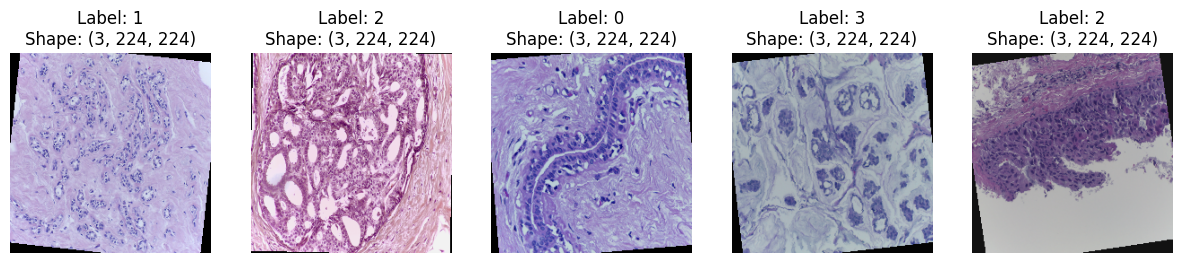


Validation Samples - Total Batches: 8 | Total Samples: 60


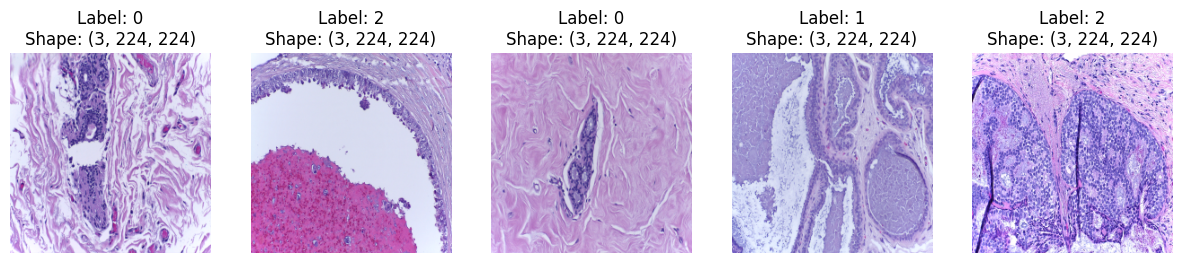


Test Samples - Total Batches: 3 | Total Samples: 20


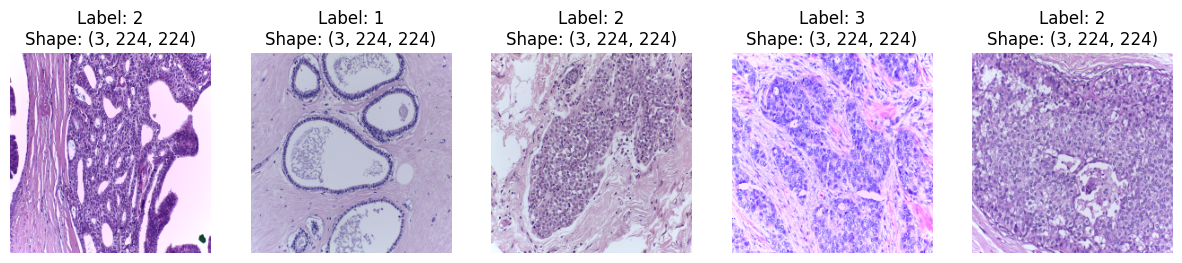

In [17]:
def show_samples(dataloader, title, num_samples=5):
    print(f"\n{title} - Total Batches: {len(dataloader)} | Total Samples: {len(dataloader.dataset)}")


    batch = next(iter(dataloader))

    if isinstance(batch, tuple) and len(batch) == 2:
        images, labels = batch
    elif isinstance(batch, list) and len(batch) == 2:
        images, labels = batch[0], batch[1]
    else:
        raise ValueError(f"Unexpected batch format from DataLoader: {type(batch)}, content: {batch}")


    if isinstance(images, list):
        images = torch.stack(images)


    if images.ndim == 3:
        images = images.unsqueeze(0)

    num_samples = min(num_samples, images.shape[0])


    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]
    for i in range(num_samples):
        img_tensor = images[i]
        img = TF.to_pil_image(img_tensor.cpu())
        label = labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]
        img_shape = tuple(img_tensor.shape)

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}\nShape: {img_shape}")
        axes[i].axis("off")



    plt.show()

show_samples(train_dataloader, "Train Samples")
show_samples(val_dataloader, "Validation Samples")
show_samples(test_dataloader, "Test Samples")

## Model Architecture & Training Configuration

Here we define the neural network architecture based on a ResNet backbone with a custom classification head adapted to the four BACH classes. We also specify the loss function, optimizer, learning rate, and other hyperparameters that control how the model learns from the data.


In [18]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)


for param in model.layer1.parameters() :
        param.requires_grad = False
for param in model.layer2.parameters() :
        param.requires_grad = False
for param in model.layer3.parameters() :
        param.requires_grad = False
for param in model.layer4.parameters() :
        param.requires_grad = True
num_features = model.fc.in_features
num_classes = 4


model.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, num_classes)
)


model = model.to(device)


criterion = nn.CrossEntropyLoss()


class_weights = torch.tensor([1.0, 1.5, 1.0, 1.0], dtype=torch.float32).to(device)


criterion_w = nn.CrossEntropyLoss(weight=class_weights)


optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=1e-4)


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5
)

In [19]:
import torch
import torch.nn.functional as F

def convert_to_one_hot(label, num_classes):


    return F.one_hot(torch.tensor(label), num_classes).float()  # Shape: (num_classes,)

def compute_multiclass_metrics(preds_list, labels_list, num_classes):

    # Initialize per-class metric accumulators
    TP_per_class = torch.zeros(num_classes)
    TN_per_class = torch.zeros(num_classes)
    FP_per_class = torch.zeros(num_classes)
    FN_per_class = torch.zeros(num_classes)

    correct = 0
    total = len(labels_list)

    for preds, label in zip(preds_list, labels_list):

        label_one_hot = convert_to_one_hot(label, num_classes)


        pred_class = torch.argmax(preds)
        pred_one_hot = convert_to_one_hot(preds, num_classes)


        if preds == label:
            correct += 1


        for class_idx in range(num_classes):

            TP_per_class[class_idx] += int((pred_one_hot[class_idx] == 1) and (label_one_hot[class_idx] == 1))

            TN_per_class[class_idx] += int((pred_one_hot[class_idx] == 0) and (label_one_hot[class_idx] == 0))

            FP_per_class[class_idx] += int((pred_one_hot[class_idx] == 1) and (label_one_hot[class_idx] == 0))

            FN_per_class[class_idx] += int((pred_one_hot[class_idx] == 0) and (label_one_hot[class_idx] == 1))


    precision_per_class = TP_per_class / (TP_per_class + FP_per_class).clamp(min=1e-10)

    recall_per_class = TP_per_class / (TP_per_class + FN_per_class).clamp(min=1e-10)

    specificity_per_class = TN_per_class / (TN_per_class + FP_per_class).clamp(min=1e-10)

    f1_score_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class).clamp(min=1e-10)



    macro_precision = precision_per_class.mean().item()
    macro_recall = recall_per_class.mean().item()
    macro_specificity = specificity_per_class.mean().item()
    macro_f1_score = f1_score_per_class.mean().item()


    accuracy = correct / total

    return {
        "accuracy": accuracy,
        "precision_per_class": precision_per_class.tolist(),
        "macro_precision": macro_precision,
        "recall_per_class": recall_per_class.tolist(),
        "macro_recall": macro_recall,
        "specificity_per_class": specificity_per_class.tolist(),
        "macro_specificity": macro_specificity,
        "f1_score_per_class": f1_score_per_class.tolist(),
        "macro_f1_score": macro_f1_score
    }

In [20]:
def plot_loss(train_losses, val_losses, num_epochs):
    """Plots training and validation loss curves."""
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o', linestyle='-')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s', linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


## Model Training & Validation

This section implements the training and validation loops. Across multiple epochs, the model is updated using the training set while performance on the validation set is monitored using metrics such as loss, accuracy, and F1-score to detect underfitting or overfitting.


In [21]:
def train_model(model, optimizer, criterion, train_dataloader, val_dataloader, num_epochs, device, num_classes, model_path, csv_name):

    log_fields = ["epoch", "time", "train_loss", "val_loss", "train_precision", "val_precision",
              "train_recall", "val_recall", "train_F1_Score", "val_F1_Score"]
    total_training_time = 0
    best_val_F1_Score = 0

    train_losses = []
    val_losses = []

    with open(csv_name, 'w', newline='', encoding='utf-8') as csvfile:
         writer = csv.DictWriter(csvfile, fieldnames=log_fields)
         writer.writeheader()

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()

        total_loss = 0
        correct = 0
        total = 0

        all_preds = []
        all_labels = []



        train_iterator = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")

        for images, labels in train_iterator:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = F.softmax(outputs, dim=1)
            preds = torch.argmax(preds, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)


            all_preds.append(preds.detach().cpu())
            all_labels.append(labels.detach().cpu())

            train_iterator.set_postfix(loss=f"{loss:.4f}")

        epoch_time = time.time() - start_time
        total_training_time += epoch_time
        accuracy = correct / total


        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.cat(all_labels, dim=0)


        metrics = compute_multiclass_metrics(all_preds, all_labels, num_classes)

        epoch_train_loss = total_loss / len(train_dataloader)
        train_losses.append(epoch_train_loss)


        # Print metrics for each class
        print(f"Epoch {epoch + 1} - Loss: {epoch_train_loss:.4f}, Accuracy: {accuracy:.4f}, Time: {epoch_time:.2f}s")
        print(f"Macro Precision: {metrics['macro_precision']:.4f}, Macro Recall: {metrics['macro_recall']:.4f}, Macro F1-score: {metrics['macro_f1_score']:.4f}")

        for class_idx in range(num_classes):
            print(f"Class {class_idx} - Precision: {metrics['precision_per_class'][class_idx]:.4f}, Recall: {metrics['recall_per_class'][class_idx]:.4f}, F1-score: {metrics['f1_score_per_class'][class_idx]:.4f}")

        all_val_preds,all_val_labels,val_accuracy, val_loss = valid_model(model,criterion, val_dataloader, device, epoch, num_classes)
        val_metrics = compute_multiclass_metrics(all_val_preds, all_val_labels, num_classes)
        val_losses.append(val_loss)
        print("Validation_Metrics")
        print(f"Epoch {epoch + 1} - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
        print(f"Macro Precision: {val_metrics['macro_precision']:.4f}, Macro Recall: {val_metrics['macro_recall']:.4f}, Macro F1-score: {val_metrics['macro_f1_score']:.4f}")

        for class_idx in range(num_classes):
            print(f"Class {class_idx} - Precision: {val_metrics['precision_per_class'][class_idx]:.4f}, Recall: {val_metrics['recall_per_class'][class_idx]:.4f}, F1-score: {val_metrics['f1_score_per_class'][class_idx]:.4f}")

            # Save best model based on Dice score
        if val_metrics['macro_f1_score'] > best_val_F1_Score:
            best_val_F1_Score = val_metrics['macro_f1_score']
            torch.save(model.state_dict(), model_path)
            print(f"Model saved at epoch {epoch+1} with F1_score: {best_val_F1_Score:.4f}")
            # Log training and validation metrics
        with open(csv_name, 'a', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=log_fields)
            writer.writerow({
                "epoch": epoch + 1,
                "time": round(epoch_time, 2),
                "train_loss": round(total_loss/len(train_dataloader), 4),
                "val_loss": round(val_loss, 4),
                "train_precision": round(metrics['macro_precision'], 4),
                "val_precision": round(val_metrics['macro_precision'], 4),
                "train_recall": round(metrics['macro_recall'], 4),
                "val_recall": round(val_metrics['macro_recall'], 4),
                "train_F1_Score": round(metrics['macro_f1_score'], 4),
                "val_F1_Score": round(val_metrics['macro_f1_score'], 4),

            })


    print(f"Training Complete in {total_training_time:.4f}s with {total_training_time/num_epochs:.4f}s per epoch with Best_F1_Score {best_val_F1_Score:.4f}.")
    print(f"Best Validation F1 Score: {best_val_F1_Score:.4f}")

    plot_loss(train_losses, val_losses, num_epochs)

In [22]:
def valid_model(model,criterion, dataloader, device, epoch, num_classes):

    all_val_preds = []
    all_val_labels = []
    val_loss = 0
    val_correct = 0
    val_total= 0
    model.eval()

    val_iterator = tqdm(dataloader, desc=f"Epoch {epoch + 1}")

    with torch.no_grad():
            for images,labels  in val_iterator:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = F.softmax(outputs, dim=1)
                preds = torch.argmax(preds, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)


                all_val_preds.append(preds.detach().cpu())
                all_val_labels.append(labels.detach().cpu())

    val_iterator.set_postfix(loss=f"{loss:.4f}")
    val_accuracy = val_correct / val_total
    all_val_preds = torch.cat(all_val_preds, dim=0)
    all_val_labels = torch.cat(all_val_labels, dim=0)
    val_loss /= len(dataloader)
    scheduler.step(val_loss)

    return all_val_preds,all_val_labels,val_accuracy, val_loss


In [27]:
def inference_model(model, model_path, dataloader, device, num_classes):


    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()

    all_preds = []
    all_labels = []

    inference_iterator = tqdm(dataloader, desc="Running Inference")

    start_time = time.time()

    with torch.no_grad():
        for images, labels in inference_iterator:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            preds = F.softmax(outputs, dim=1)
            preds = torch.argmax(preds, dim=1)


            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())


    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)


    metrics = compute_multiclass_metrics(all_preds, all_labels, num_classes)

    # confusion matrix heatmap
    # Convert tensors to numpy arrays
    y_true = all_labels.numpy()
    y_pred = all_preds.numpy()

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Class names must match your label encoding:
    # "Normal": 0, "Benign": 1, "InSitu": 2, "Invasive": 3
    class_names = ["Normal", "Benign", "InSitu", "Invasive"]

    # Plot confusion matrix
    plot_confusion_matrix(
        cm,
        class_names=class_names,
        title="Confusion Matrix - Test Set",

        save_path="confusion_matrix_test.png"  # or None if you don't want to save
    )


    inference_time = time.time() - start_time
    print(f"\nInference Completed in {inference_time:.2f}s")

    print(f"\nMacro Precision: {metrics['macro_precision']:.4f}, Macro Recall: {metrics['macro_recall']:.4f}, Macro F1-score: {metrics['macro_f1_score']:.4f}")

    for class_idx in range(num_classes):
        print(f"Class {class_idx} - Precision: {metrics['precision_per_class'][class_idx]:.4f}, Recall: {metrics['recall_per_class'][class_idx]:.4f}, F1-score: {metrics['f1_score_per_class'][class_idx]:.4f}")




In [36]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix", save_path=None):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="gray_r",
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=0.5,
        linecolor=None#'black'
    )
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Confusion matrix saved to: {save_path}")

    plt.show()


Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 - Loss: 1.3828, Accuracy: 0.2875, Time: 421.60s
Macro Precision: 0.2030, Macro Recall: 0.2875, Macro F1-score: 0.2087
Class 0 - Precision: 0.2756, Recall: 0.4375, F1-score: 0.3382
Class 1 - Precision: 0.2353, Recall: 0.0500, F1-score: 0.0825
Class 2 - Precision: 0.3011, Recall: 0.6625, F1-score: 0.4141
Class 3 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


/tmp/ipython-input-324665692.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return F.one_hot(torch.tensor(label), num_classes).float()  # Shape: (num_classes,)


Epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 1 - Loss: 1.3633, Accuracy: 0.4333
Macro Precision: 0.2271, Macro Recall: 0.4333, Macro F1-score: 0.2917
Class 0 - Precision: 0.3846, Recall: 1.0000, F1-score: 0.5556
Class 1 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Class 2 - Precision: 0.5238, Recall: 0.7333, F1-score: 0.6111
Class 3 - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
Model saved at epoch 1 with F1_score: 0.2917


Epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2 - Loss: 1.3258, Accuracy: 0.4781, Time: 21.10s
Macro Precision: 0.5053, Macro Recall: 0.4781, Macro F1-score: 0.4510
Class 0 - Precision: 0.5083, Recall: 0.7625, F1-score: 0.6100
Class 1 - Precision: 0.2807, Recall: 0.2000, F1-score: 0.2336
Class 2 - Precision: 0.4737, Recall: 0.6750, F1-score: 0.5567
Class 3 - Precision: 0.7586, Recall: 0.2750, F1-score: 0.4037


Epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 2 - Loss: 1.1695, Accuracy: 0.6833
Macro Precision: 0.7937, Macro Recall: 0.6833, Macro F1-score: 0.6339
Class 0 - Precision: 0.5357, Recall: 1.0000, F1-score: 0.6977
Class 1 - Precision: 1.0000, Recall: 0.1333, F1-score: 0.2353
Class 2 - Precision: 0.7222, Recall: 0.8667, F1-score: 0.7879
Class 3 - Precision: 0.9167, Recall: 0.7333, F1-score: 0.8148
Model saved at epoch 2 with F1_score: 0.6339


Epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3 - Loss: 1.0076, Accuracy: 0.6469, Time: 20.89s
Macro Precision: 0.6268, Macro Recall: 0.6469, Macro F1-score: 0.6121
Class 0 - Precision: 0.6214, Recall: 0.8000, F1-score: 0.6995
Class 1 - Precision: 0.5172, Recall: 0.1875, F1-score: 0.2752
Class 2 - Precision: 0.6300, Recall: 0.7875, F1-score: 0.7000
Class 3 - Precision: 0.7386, Recall: 0.8125, F1-score: 0.7738


Epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 3 - Loss: 0.7937, Accuracy: 0.7000
Macro Precision: 0.7216, Macro Recall: 0.7000, Macro F1-score: 0.6747
Class 0 - Precision: 0.5769, Recall: 1.0000, F1-score: 0.7317
Class 1 - Precision: 0.6667, Recall: 0.2667, F1-score: 0.3810
Class 2 - Precision: 0.7857, Recall: 0.7333, F1-score: 0.7586
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276
Model saved at epoch 3 with F1_score: 0.6747


Epoch 4:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4 - Loss: 0.7647, Accuracy: 0.6937, Time: 21.44s
Macro Precision: 0.6732, Macro Recall: 0.6938, Macro F1-score: 0.6745
Class 0 - Precision: 0.6667, Recall: 0.8250, F1-score: 0.7374
Class 1 - Precision: 0.5000, Recall: 0.3000, F1-score: 0.3750
Class 2 - Precision: 0.7647, Recall: 0.8125, F1-score: 0.7879
Class 3 - Precision: 0.7614, Recall: 0.8375, F1-score: 0.7976


Epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 4 - Loss: 0.6950, Accuracy: 0.7167
Macro Precision: 0.7157, Macro Recall: 0.7167, Macro F1-score: 0.6945
Class 0 - Precision: 0.7368, Recall: 0.9333, F1-score: 0.8235
Class 1 - Precision: 0.7143, Recall: 0.3333, F1-score: 0.4545
Class 2 - Precision: 0.6471, Recall: 0.7333, F1-score: 0.6875
Class 3 - Precision: 0.7647, Recall: 0.8667, F1-score: 0.8125
Model saved at epoch 4 with F1_score: 0.6945


Epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5 - Loss: 0.6244, Accuracy: 0.7531, Time: 21.05s
Macro Precision: 0.7426, Macro Recall: 0.7531, Macro F1-score: 0.7385
Class 0 - Precision: 0.7640, Recall: 0.8500, F1-score: 0.8047
Class 1 - Precision: 0.6600, Recall: 0.4125, F1-score: 0.5077
Class 2 - Precision: 0.7528, Recall: 0.8375, F1-score: 0.7929
Class 3 - Precision: 0.7935, Recall: 0.9125, F1-score: 0.8488


Epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 5 - Loss: 0.7220, Accuracy: 0.7833
Macro Precision: 0.8164, Macro Recall: 0.7833, Macro F1-score: 0.7826
Class 0 - Precision: 0.6364, Recall: 0.9333, F1-score: 0.7568
Class 1 - Precision: 0.9000, Recall: 0.6000, F1-score: 0.7200
Class 2 - Precision: 0.9167, Recall: 0.7333, F1-score: 0.8148
Class 3 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Model saved at epoch 5 with F1_score: 0.7826


Epoch 6:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6 - Loss: 0.5193, Accuracy: 0.8219, Time: 21.33s
Macro Precision: 0.8176, Macro Recall: 0.8219, Macro F1-score: 0.8176
Class 0 - Precision: 0.8250, Recall: 0.8250, F1-score: 0.8250
Class 1 - Precision: 0.7463, Recall: 0.6250, F1-score: 0.6803
Class 2 - Precision: 0.8452, Recall: 0.8875, F1-score: 0.8659
Class 3 - Precision: 0.8539, Recall: 0.9500, F1-score: 0.8994


Epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 6 - Loss: 0.6456, Accuracy: 0.8000
Macro Precision: 0.8072, Macro Recall: 0.8000, Macro F1-score: 0.7972
Class 0 - Precision: 0.7368, Recall: 0.9333, F1-score: 0.8235
Class 1 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 2 - Precision: 0.8462, Recall: 0.7333, F1-score: 0.7857
Class 3 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Model saved at epoch 6 with F1_score: 0.7972


Epoch 7:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7 - Loss: 0.4115, Accuracy: 0.8500, Time: 21.11s
Macro Precision: 0.8496, Macro Recall: 0.8500, Macro F1-score: 0.8495
Class 0 - Precision: 0.8148, Recall: 0.8250, F1-score: 0.8199
Class 1 - Precision: 0.7308, Recall: 0.7125, F1-score: 0.7215
Class 2 - Precision: 0.9481, Recall: 0.9125, F1-score: 0.9299
Class 3 - Precision: 0.9048, Recall: 0.9500, F1-score: 0.9268


Epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 7 - Loss: 0.7100, Accuracy: 0.7833
Macro Precision: 0.7902, Macro Recall: 0.7833, Macro F1-score: 0.7813
Class 0 - Precision: 0.7368, Recall: 0.9333, F1-score: 0.8235
Class 1 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 2 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 8:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8 - Loss: 0.3199, Accuracy: 0.8938, Time: 21.26s
Macro Precision: 0.8942, Macro Recall: 0.8938, Macro F1-score: 0.8935
Class 0 - Precision: 0.9359, Recall: 0.9125, F1-score: 0.9241
Class 1 - Precision: 0.7975, Recall: 0.7875, F1-score: 0.7925
Class 2 - Precision: 0.9481, Recall: 0.9125, F1-score: 0.9299
Class 3 - Precision: 0.8953, Recall: 0.9625, F1-score: 0.9277


Epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 8 - Loss: 0.6422, Accuracy: 0.7667
Macro Precision: 0.7680, Macro Recall: 0.7667, Macro F1-score: 0.7631
Class 0 - Precision: 0.7368, Recall: 0.9333, F1-score: 0.8235
Class 1 - Precision: 0.6923, Recall: 0.6000, F1-score: 0.6429
Class 2 - Precision: 0.7857, Recall: 0.7333, F1-score: 0.7586
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 9:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9 - Loss: 0.3134, Accuracy: 0.8844, Time: 21.48s
Macro Precision: 0.8851, Macro Recall: 0.8844, Macro F1-score: 0.8847
Class 0 - Precision: 0.8861, Recall: 0.8750, F1-score: 0.8805
Class 1 - Precision: 0.8049, Recall: 0.8250, F1-score: 0.8148
Class 2 - Precision: 0.9136, Recall: 0.9250, F1-score: 0.9193
Class 3 - Precision: 0.9359, Recall: 0.9125, F1-score: 0.9241


Epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 9 - Loss: 0.6904, Accuracy: 0.7833
Macro Precision: 0.7827, Macro Recall: 0.7833, Macro F1-score: 0.7764
Class 0 - Precision: 0.7368, Recall: 0.9333, F1-score: 0.8235
Class 1 - Precision: 0.7273, Recall: 0.5333, F1-score: 0.6154
Class 2 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000
Class 3 - Precision: 0.8667, Recall: 0.8667, F1-score: 0.8667


Epoch 10:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10 - Loss: 0.2733, Accuracy: 0.9000, Time: 21.14s
Macro Precision: 0.8999, Macro Recall: 0.9000, Macro F1-score: 0.8999
Class 0 - Precision: 0.9241, Recall: 0.9125, F1-score: 0.9182
Class 1 - Precision: 0.8481, Recall: 0.8375, F1-score: 0.8428
Class 2 - Precision: 0.9250, Recall: 0.9250, F1-score: 0.9250
Class 3 - Precision: 0.9024, Recall: 0.9250, F1-score: 0.9136


Epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 10 - Loss: 0.5940, Accuracy: 0.7500
Macro Precision: 0.7533, Macro Recall: 0.7500, Macro F1-score: 0.7462
Class 0 - Precision: 0.7368, Recall: 0.9333, F1-score: 0.8235
Class 1 - Precision: 0.6429, Recall: 0.6000, F1-score: 0.6207
Class 2 - Precision: 0.8333, Recall: 0.6667, F1-score: 0.7407
Class 3 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000


Epoch 11:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11 - Loss: 0.2703, Accuracy: 0.8969, Time: 21.00s
Macro Precision: 0.8992, Macro Recall: 0.8969, Macro F1-score: 0.8976
Class 0 - Precision: 0.9351, Recall: 0.9000, F1-score: 0.9172
Class 1 - Precision: 0.8072, Recall: 0.8375, F1-score: 0.8221
Class 2 - Precision: 0.9737, Recall: 0.9250, F1-score: 0.9487
Class 3 - Precision: 0.8810, Recall: 0.9250, F1-score: 0.9024


Epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 11 - Loss: 0.7107, Accuracy: 0.8000
Macro Precision: 0.8032, Macro Recall: 0.8000, Macro F1-score: 0.7978
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.6923, Recall: 0.6000, F1-score: 0.6429
Class 2 - Precision: 0.7222, Recall: 0.8667, F1-score: 0.7879
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571
Model saved at epoch 11 with F1_score: 0.7978


Epoch 12:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12 - Loss: 0.2091, Accuracy: 0.9219, Time: 21.68s
Macro Precision: 0.9225, Macro Recall: 0.9219, Macro F1-score: 0.9218
Class 0 - Precision: 0.9467, Recall: 0.8875, F1-score: 0.9161
Class 1 - Precision: 0.8415, Recall: 0.8625, F1-score: 0.8519
Class 2 - Precision: 0.9634, Recall: 0.9875, F1-score: 0.9753
Class 3 - Precision: 0.9383, Recall: 0.9500, F1-score: 0.9441


Epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 12 - Loss: 0.7041, Accuracy: 0.8000
Macro Precision: 0.8098, Macro Recall: 0.8000, Macro F1-score: 0.8001
Class 0 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 1 - Precision: 0.6875, Recall: 0.7333, F1-score: 0.7097
Class 2 - Precision: 0.9167, Recall: 0.7333, F1-score: 0.8148
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276
Model saved at epoch 12 with F1_score: 0.8001


Epoch 13:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13 - Loss: 0.1904, Accuracy: 0.9281, Time: 21.14s
Macro Precision: 0.9287, Macro Recall: 0.9281, Macro F1-score: 0.9283
Class 0 - Precision: 0.9036, Recall: 0.9375, F1-score: 0.9202
Class 1 - Precision: 0.8875, Recall: 0.8875, F1-score: 0.8875
Class 2 - Precision: 0.9494, Recall: 0.9375, F1-score: 0.9434
Class 3 - Precision: 0.9744, Recall: 0.9500, F1-score: 0.9620


Epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 13 - Loss: 0.8180, Accuracy: 0.7500
Macro Precision: 0.7598, Macro Recall: 0.7500, Macro F1-score: 0.7492
Class 0 - Precision: 0.7368, Recall: 0.9333, F1-score: 0.8235
Class 1 - Precision: 0.6000, Recall: 0.6000, F1-score: 0.6000
Class 2 - Precision: 0.7857, Recall: 0.7333, F1-score: 0.7586
Class 3 - Precision: 0.9167, Recall: 0.7333, F1-score: 0.8148


Epoch 14:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14 - Loss: 0.1609, Accuracy: 0.9344, Time: 20.98s
Macro Precision: 0.9351, Macro Recall: 0.9344, Macro F1-score: 0.9346
Class 0 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 1 - Precision: 0.8780, Recall: 0.9000, F1-score: 0.8889
Class 2 - Precision: 0.9383, Recall: 0.9500, F1-score: 0.9441
Class 3 - Precision: 0.9367, Recall: 0.9250, F1-score: 0.9308


Epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 14 - Loss: 0.8938, Accuracy: 0.7667
Macro Precision: 0.7928, Macro Recall: 0.7667, Macro F1-score: 0.7701
Class 0 - Precision: 0.7368, Recall: 0.9333, F1-score: 0.8235
Class 1 - Precision: 0.5882, Recall: 0.6667, F1-score: 0.6250
Class 2 - Precision: 1.0000, Recall: 0.7333, F1-score: 0.8462
Class 3 - Precision: 0.8462, Recall: 0.7333, F1-score: 0.7857


Epoch 15:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15 - Loss: 0.1299, Accuracy: 0.9563, Time: 21.24s
Macro Precision: 0.9563, Macro Recall: 0.9562, Macro F1-score: 0.9562
Class 0 - Precision: 0.9747, Recall: 0.9625, F1-score: 0.9686
Class 1 - Precision: 0.9241, Recall: 0.9125, F1-score: 0.9182
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 0.9390, Recall: 0.9625, F1-score: 0.9506


Epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 15 - Loss: 0.8313, Accuracy: 0.8000
Macro Precision: 0.8116, Macro Recall: 0.8000, Macro F1-score: 0.7996
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6471, Recall: 0.7333, F1-score: 0.6875
Class 2 - Precision: 0.8667, Recall: 0.8667, F1-score: 0.8667
Class 3 - Precision: 0.9091, Recall: 0.6667, F1-score: 0.7692


Epoch 16:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16 - Loss: 0.1010, Accuracy: 0.9625, Time: 20.80s
Macro Precision: 0.9627, Macro Recall: 0.9625, Macro F1-score: 0.9626
Class 0 - Precision: 0.9625, Recall: 0.9625, F1-score: 0.9625
Class 1 - Precision: 0.9259, Recall: 0.9375, F1-score: 0.9317
Class 2 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 3 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814


Epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 16 - Loss: 0.8596, Accuracy: 0.8000
Macro Precision: 0.8073, Macro Recall: 0.8000, Macro F1-score: 0.8005
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.6250, Recall: 0.6667, F1-score: 0.6452
Class 2 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Class 3 - Precision: 0.9167, Recall: 0.7333, F1-score: 0.8148
Model saved at epoch 16 with F1_score: 0.8005


Epoch 17:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17 - Loss: 0.0536, Accuracy: 0.9938, Time: 21.50s
Macro Precision: 0.9937, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 17 - Loss: 0.8590, Accuracy: 0.8333
Macro Precision: 0.8467, Macro Recall: 0.8333, Macro F1-score: 0.8355
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.6667, Recall: 0.8000, F1-score: 0.7273
Class 2 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 3 - Precision: 0.9167, Recall: 0.7333, F1-score: 0.8148
Model saved at epoch 17 with F1_score: 0.8355


Epoch 18:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18 - Loss: 0.0481, Accuracy: 0.9875, Time: 21.41s
Macro Precision: 0.9875, Macro Recall: 0.9875, Macro F1-score: 0.9875
Class 0 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 1 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 18 - Loss: 0.8439, Accuracy: 0.8000
Macro Precision: 0.7997, Macro Recall: 0.8000, Macro F1-score: 0.7994
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276
Class 3 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000


Epoch 19:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19 - Loss: 0.0374, Accuracy: 0.9906, Time: 21.12s
Macro Precision: 0.9908, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 2 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877
Class 3 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875


Epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 19 - Loss: 0.9950, Accuracy: 0.8333
Macro Precision: 0.8467, Macro Recall: 0.8333, Macro F1-score: 0.8355
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.6667, Recall: 0.8000, F1-score: 0.7273
Class 2 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 3 - Precision: 0.9167, Recall: 0.7333, F1-score: 0.8148


Epoch 20:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20 - Loss: 0.0470, Accuracy: 0.9844, Time: 21.26s
Macro Precision: 0.9847, Macro Recall: 0.9844, Macro F1-score: 0.9844
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 2 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 3 - Precision: 0.9639, Recall: 1.0000, F1-score: 0.9816


Epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 20 - Loss: 0.9042, Accuracy: 0.8167
Macro Precision: 0.8277, Macro Recall: 0.8167, Macro F1-score: 0.8183
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.6667, Recall: 0.8000, F1-score: 0.7273
Class 2 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571
Class 3 - Precision: 0.8462, Recall: 0.7333, F1-score: 0.7857


Epoch 21:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21 - Loss: 0.0536, Accuracy: 0.9750, Time: 21.44s
Macro Precision: 0.9749, Macro Recall: 0.9750, Macro F1-score: 0.9749
Class 0 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 1 - Precision: 0.9615, Recall: 0.9375, F1-score: 0.9494
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814


Epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 21 - Loss: 1.0846, Accuracy: 0.8167
Macro Precision: 0.8263, Macro Recall: 0.8167, Macro F1-score: 0.8181
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.6471, Recall: 0.7333, F1-score: 0.6875
Class 2 - Precision: 0.8667, Recall: 0.8667, F1-score: 0.8667
Class 3 - Precision: 0.9167, Recall: 0.7333, F1-score: 0.8148


Epoch 22:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22 - Loss: 0.0452, Accuracy: 0.9906, Time: 21.40s
Macro Precision: 0.9906, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 1 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875


Epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 22 - Loss: 0.9238, Accuracy: 0.7833
Macro Precision: 0.7834, Macro Recall: 0.7833, Macro F1-score: 0.7819
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.6000, Recall: 0.6000, F1-score: 0.6000
Class 2 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Class 3 - Precision: 0.8462, Recall: 0.7333, F1-score: 0.7857


Epoch 23:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23 - Loss: 0.0370, Accuracy: 0.9875, Time: 21.51s
Macro Precision: 0.9876, Macro Recall: 0.9875, Macro F1-score: 0.9875
Class 0 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 1 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 23 - Loss: 0.9136, Accuracy: 0.8167
Macro Precision: 0.8178, Macro Recall: 0.8167, Macro F1-score: 0.8159
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 2 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 24:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24 - Loss: 0.0340, Accuracy: 0.9906, Time: 21.18s
Macro Precision: 0.9908, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 1 - Precision: 1.0000, Recall: 0.9625, F1-score: 0.9809
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877


Epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 24 - Loss: 0.9458, Accuracy: 0.8000
Macro Precision: 0.7987, Macro Recall: 0.8000, Macro F1-score: 0.7981
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7143, Recall: 0.6667, F1-score: 0.6897
Class 2 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 25:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25 - Loss: 0.0235, Accuracy: 1.0000, Time: 21.55s
Macro Precision: 1.0000, Macro Recall: 1.0000, Macro F1-score: 1.0000
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 25 - Loss: 1.0152, Accuracy: 0.8000
Macro Precision: 0.7997, Macro Recall: 0.8000, Macro F1-score: 0.7994
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 26:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26 - Loss: 0.0289, Accuracy: 0.9906, Time: 21.47s
Macro Precision: 0.9908, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877


Epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 26 - Loss: 0.9169, Accuracy: 0.7833
Macro Precision: 0.7882, Macro Recall: 0.7833, Macro F1-score: 0.7821
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6000, Recall: 0.6000, F1-score: 0.6000
Class 2 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Class 3 - Precision: 0.9167, Recall: 0.7333, F1-score: 0.8148


Epoch 27:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27 - Loss: 0.0374, Accuracy: 0.9906, Time: 21.25s
Macro Precision: 0.9907, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 1 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 27 - Loss: 1.0405, Accuracy: 0.8000
Macro Precision: 0.8048, Macro Recall: 0.8000, Macro F1-score: 0.7988
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Class 3 - Precision: 0.9167, Recall: 0.7333, F1-score: 0.8148


Epoch 28:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28 - Loss: 0.0317, Accuracy: 0.9875, Time: 21.59s
Macro Precision: 0.9876, Macro Recall: 0.9875, Macro F1-score: 0.9875
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9750, Recall: 0.9750, F1-score: 0.9750
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814


Epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 28 - Loss: 0.9349, Accuracy: 0.8167
Macro Precision: 0.8193, Macro Recall: 0.8167, Macro F1-score: 0.8164
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.6667, Recall: 0.6667, F1-score: 0.6667
Class 2 - Precision: 0.8125, Recall: 0.8667, F1-score: 0.8387
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 29:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29 - Loss: 0.0352, Accuracy: 0.9906, Time: 21.27s
Macro Precision: 0.9908, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 1 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 29 - Loss: 1.0556, Accuracy: 0.8333
Macro Precision: 0.8367, Macro Recall: 0.8333, Macro F1-score: 0.8330
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 2 - Precision: 0.8667, Recall: 0.8667, F1-score: 0.8667
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 30:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30 - Loss: 0.0372, Accuracy: 0.9875, Time: 21.37s
Macro Precision: 0.9875, Macro Recall: 0.9875, Macro F1-score: 0.9875
Class 0 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 1 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 30 - Loss: 0.9590, Accuracy: 0.8167
Macro Precision: 0.8205, Macro Recall: 0.8167, Macro F1-score: 0.8155
Class 0 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 1 - Precision: 0.7143, Recall: 0.6667, F1-score: 0.6897
Class 2 - Precision: 0.8667, Recall: 0.8667, F1-score: 0.8667
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 31:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31 - Loss: 0.0317, Accuracy: 0.9906, Time: 21.33s
Macro Precision: 0.9907, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 1 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 31 - Loss: 0.9546, Accuracy: 0.8333
Macro Precision: 0.8467, Macro Recall: 0.8333, Macro F1-score: 0.8355
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.6667, Recall: 0.8000, F1-score: 0.7273
Class 2 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 3 - Precision: 0.9167, Recall: 0.7333, F1-score: 0.8148


Epoch 32:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32 - Loss: 0.0490, Accuracy: 0.9812, Time: 21.44s
Macro Precision: 0.9816, Macro Recall: 0.9812, Macro F1-score: 0.9812
Class 0 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 1 - Precision: 0.9630, Recall: 0.9750, F1-score: 0.9689
Class 2 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877
Class 3 - Precision: 1.0000, Recall: 0.9500, F1-score: 0.9744


Epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 32 - Loss: 0.8868, Accuracy: 0.8333
Macro Precision: 0.8371, Macro Recall: 0.8333, Macro F1-score: 0.8343
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.6875, Recall: 0.7333, F1-score: 0.7097
Class 2 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 33:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33 - Loss: 0.0238, Accuracy: 0.9938, Time: 21.32s
Macro Precision: 0.9939, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 1 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 33 - Loss: 1.0482, Accuracy: 0.8167
Macro Precision: 0.8178, Macro Recall: 0.8167, Macro F1-score: 0.8159
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 2 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 34:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34 - Loss: 0.0308, Accuracy: 0.9906, Time: 21.49s
Macro Precision: 0.9907, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 34 - Loss: 0.8772, Accuracy: 0.8333
Macro Precision: 0.8356, Macro Recall: 0.8333, Macro F1-score: 0.8331
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 2 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 35:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35 - Loss: 0.0228, Accuracy: 0.9969, Time: 21.34s
Macro Precision: 0.9969, Macro Recall: 0.9969, Macro F1-score: 0.9969
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 35 - Loss: 0.9010, Accuracy: 0.8000
Macro Precision: 0.7987, Macro Recall: 0.8000, Macro F1-score: 0.7981
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7143, Recall: 0.6667, F1-score: 0.6897
Class 2 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276
Class 3 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000


Epoch 36:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36 - Loss: 0.0300, Accuracy: 0.9938, Time: 21.49s
Macro Precision: 0.9938, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 1 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 36 - Loss: 1.0404, Accuracy: 0.8167
Macro Precision: 0.8178, Macro Recall: 0.8167, Macro F1-score: 0.8159
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 2 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 37:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37 - Loss: 0.0179, Accuracy: 1.0000, Time: 21.61s
Macro Precision: 1.0000, Macro Recall: 1.0000, Macro F1-score: 1.0000
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 37 - Loss: 0.9328, Accuracy: 0.7833
Macro Precision: 0.7818, Macro Recall: 0.7833, Macro F1-score: 0.7797
Class 0 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 1 - Precision: 0.6923, Recall: 0.6000, F1-score: 0.6429
Class 2 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276
Class 3 - Precision: 0.8000, Recall: 0.8000, F1-score: 0.8000


Epoch 38:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38 - Loss: 0.0301, Accuracy: 0.9906, Time: 21.22s
Macro Precision: 0.9910, Macro Recall: 0.9906, Macro F1-score: 0.9907
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9639, Recall: 1.0000, F1-score: 0.9816
Class 2 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 38 - Loss: 1.0133, Accuracy: 0.8333
Macro Precision: 0.8367, Macro Recall: 0.8333, Macro F1-score: 0.8330
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 2 - Precision: 0.8667, Recall: 0.8667, F1-score: 0.8667
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 39:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39 - Loss: 0.0259, Accuracy: 0.9938, Time: 21.41s
Macro Precision: 0.9938, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 1 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 2 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 39 - Loss: 1.0586, Accuracy: 0.8500
Macro Precision: 0.8581, Macro Recall: 0.8500, Macro F1-score: 0.8517
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.7059, Recall: 0.8000, F1-score: 0.7500
Class 2 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571
Model saved at epoch 39 with F1_score: 0.8517


Epoch 40:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40 - Loss: 0.0201, Accuracy: 0.9938, Time: 21.61s
Macro Precision: 0.9938, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 40 - Loss: 1.0289, Accuracy: 0.8167
Macro Precision: 0.8205, Macro Recall: 0.8167, Macro F1-score: 0.8155
Class 0 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 1 - Precision: 0.7143, Recall: 0.6667, F1-score: 0.6897
Class 2 - Precision: 0.8667, Recall: 0.8667, F1-score: 0.8667
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 41:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41 - Loss: 0.0321, Accuracy: 0.9906, Time: 21.67s
Macro Precision: 0.9906, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 1 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 41 - Loss: 1.0423, Accuracy: 0.8167
Macro Precision: 0.8205, Macro Recall: 0.8167, Macro F1-score: 0.8155
Class 0 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 1 - Precision: 0.7143, Recall: 0.6667, F1-score: 0.6897
Class 2 - Precision: 0.8667, Recall: 0.8667, F1-score: 0.8667
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 42:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42 - Loss: 0.0238, Accuracy: 0.9969, Time: 21.33s
Macro Precision: 0.9969, Macro Recall: 0.9969, Macro F1-score: 0.9969
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


Epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 42 - Loss: 0.9637, Accuracy: 0.8333
Macro Precision: 0.8381, Macro Recall: 0.8333, Macro F1-score: 0.8342
Class 0 - Precision: 0.8750, Recall: 0.9333, F1-score: 0.9032
Class 1 - Precision: 0.6875, Recall: 0.7333, F1-score: 0.7097
Class 2 - Precision: 0.8667, Recall: 0.8667, F1-score: 0.8667
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 43:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43 - Loss: 0.0467, Accuracy: 0.9844, Time: 21.48s
Macro Precision: 0.9846, Macro Recall: 0.9844, Macro F1-score: 0.9843
Class 0 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873
Class 1 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877
Class 2 - Precision: 0.9872, Recall: 0.9625, F1-score: 0.9747
Class 3 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877


Epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 43 - Loss: 0.9069, Accuracy: 0.8500
Macro Precision: 0.8563, Macro Recall: 0.8500, Macro F1-score: 0.8507
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7500, Recall: 0.8000, F1-score: 0.7742
Class 2 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 44:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44 - Loss: 0.0218, Accuracy: 0.9938, Time: 21.54s
Macro Precision: 0.9937, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875


Epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 44 - Loss: 1.2060, Accuracy: 0.8000
Macro Precision: 0.8016, Macro Recall: 0.8000, Macro F1-score: 0.7983
Class 0 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 1 - Precision: 0.7143, Recall: 0.6667, F1-score: 0.6897
Class 2 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 45:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45 - Loss: 0.0214, Accuracy: 0.9938, Time: 21.38s
Macro Precision: 0.9938, Macro Recall: 0.9937, Macro F1-score: 0.9937
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938


Epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 45 - Loss: 0.9410, Accuracy: 0.8000
Macro Precision: 0.8016, Macro Recall: 0.8000, Macro F1-score: 0.7983
Class 0 - Precision: 0.7778, Recall: 0.9333, F1-score: 0.8485
Class 1 - Precision: 0.7143, Recall: 0.6667, F1-score: 0.6897
Class 2 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 46:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46 - Loss: 0.0270, Accuracy: 0.9906, Time: 21.34s
Macro Precision: 0.9908, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 1 - Precision: 1.0000, Recall: 0.9625, F1-score: 0.9809
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877


Epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 46 - Loss: 0.9284, Accuracy: 0.8167
Macro Precision: 0.8178, Macro Recall: 0.8167, Macro F1-score: 0.8159
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 2 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 47:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47 - Loss: 0.0285, Accuracy: 0.9906, Time: 21.46s
Macro Precision: 0.9907, Macro Recall: 0.9906, Macro F1-score: 0.9906
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9873, Recall: 0.9750, F1-score: 0.9811
Class 2 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 3 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877


Epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 47 - Loss: 0.9223, Accuracy: 0.8333
Macro Precision: 0.8367, Macro Recall: 0.8333, Macro F1-score: 0.8330
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 2 - Precision: 0.8667, Recall: 0.8667, F1-score: 0.8667
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571


Epoch 48:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48 - Loss: 0.0207, Accuracy: 0.9938, Time: 21.62s
Macro Precision: 0.9939, Macro Recall: 0.9937, Macro F1-score: 0.9938
Class 0 - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Class 1 - Precision: 0.9756, Recall: 1.0000, F1-score: 0.9877
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 48 - Loss: 1.0029, Accuracy: 0.8167
Macro Precision: 0.8178, Macro Recall: 0.8167, Macro F1-score: 0.8159
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7333, Recall: 0.7333, F1-score: 0.7333
Class 2 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276
Class 3 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276


Epoch 49:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49 - Loss: 0.0266, Accuracy: 0.9906, Time: 21.46s
Macro Precision: 0.9910, Macro Recall: 0.9906, Macro F1-score: 0.9907
Class 0 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 1 - Precision: 0.9639, Recall: 1.0000, F1-score: 0.9816
Class 2 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937
Class 3 - Precision: 1.0000, Recall: 0.9875, F1-score: 0.9937


Epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 49 - Loss: 1.1675, Accuracy: 0.8000
Macro Precision: 0.8036, Macro Recall: 0.8000, Macro F1-score: 0.7995
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.6875, Recall: 0.7333, F1-score: 0.7097
Class 2 - Precision: 0.8571, Recall: 0.8000, F1-score: 0.8276
Class 3 - Precision: 0.8462, Recall: 0.7333, F1-score: 0.7857


Epoch 50:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50 - Loss: 0.0264, Accuracy: 0.9875, Time: 21.63s
Macro Precision: 0.9876, Macro Recall: 0.9875, Macro F1-score: 0.9875
Class 0 - Precision: 0.9877, Recall: 1.0000, F1-score: 0.9938
Class 1 - Precision: 0.9753, Recall: 0.9875, F1-score: 0.9814
Class 2 - Precision: 0.9875, Recall: 0.9875, F1-score: 0.9875
Class 3 - Precision: 1.0000, Recall: 0.9750, F1-score: 0.9873


Epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Validation_Metrics
Epoch 50 - Loss: 0.8811, Accuracy: 0.8500
Macro Precision: 0.8563, Macro Recall: 0.8500, Macro F1-score: 0.8507
Class 0 - Precision: 0.8235, Recall: 0.9333, F1-score: 0.8750
Class 1 - Precision: 0.7500, Recall: 0.8000, F1-score: 0.7742
Class 2 - Precision: 0.9286, Recall: 0.8667, F1-score: 0.8966
Class 3 - Precision: 0.9231, Recall: 0.8000, F1-score: 0.8571
Training Complete in 1467.7172s with 29.3543s per epoch with Best_F1_Score 0.8517.
Best Validation F1 Score: 0.8517


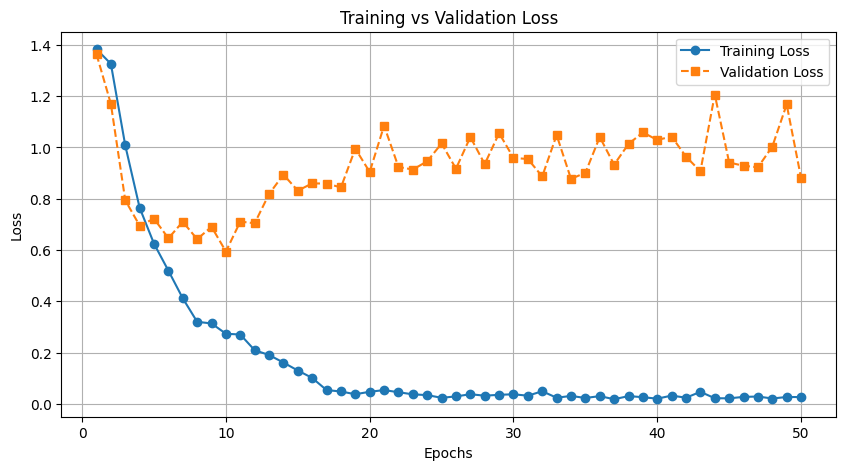

In [18]:
train_model(model, optimizer, criterion, train_dataloader, val_dataloader, config.num_epochs, device,config.num_classes, model_path="best_model1.pth", csv_name="training_results1.csv")

In [22]:
ls ./drive/MyDrive/umich_courses/1_fall_2025/1_term_project/code/

'[active-compile-term-project].ipynb'
'[active-staged]multi-class-breast-cancer-classification-with-cbam.ipynb'
 deprecated/
 pathological-classification.ipynb
 training_history.pkl
 training_model.h5
 training_model.keras


## Test Evaluation & Result Visualization

Here we evaluate the trained model on the held-out test set to estimate real-world performance. Metrics and visualizations such as confusion matrices and sample predictions are used to understand how well the model distinguishes between the different breast cancer subtypes.


Running Inference:   0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipython-input-324665692.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return F.one_hot(torch.tensor(label), num_classes).float()  # Shape: (num_classes,)


Confusion matrix saved to: confusion_matrix_test.png


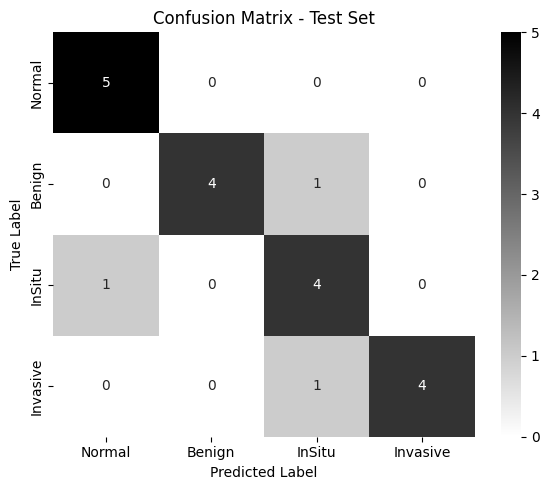


Inference Completed in 1.62s

Macro Precision: 0.8750, Macro Recall: 0.8500, Macro F1-score: 0.8535
Class 0 - Precision: 0.8333, Recall: 1.0000, F1-score: 0.9091
Class 1 - Precision: 1.0000, Recall: 0.8000, F1-score: 0.8889
Class 2 - Precision: 0.6667, Recall: 0.8000, F1-score: 0.7273
Class 3 - Precision: 1.0000, Recall: 0.8000, F1-score: 0.8889


In [38]:
best_model_path = "./drive/MyDrive/umich_courses/1_fall_2025/1_term_project/code/best_model1.pth"
inference_model(model, best_model_path, test_dataloader, device, config.num_classes)